In [103]:
import numpy as np
import scipy.signal.windows as win
import matplotlib.pyplot as plt



SAMPLEFREQ = 44100
FRAMESIZE = 1024
NOFFRAMES = 220

## Record Audio

In [104]:
    %%script false

import pyaudio

def recordAudio():
    p = pyaudio.PyAudio()
    FORMAT = pyaudio.paInt16

    stream = p.open(format=FORMAT, channels=1, rate=SAMPLEFREQ, input=True, frames_per_buffer=FRAMESIZE)
    data = stream.read(NOFFRAMES*FRAMESIZE)
    decoded = np.frombuffer(data, "int16")
    stream.stop_stream()
    stream.close()
    return decoded

data = recordAudio()
plt.plot(data)
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()



Couldn't find program: 'false'


# Input normalisieren

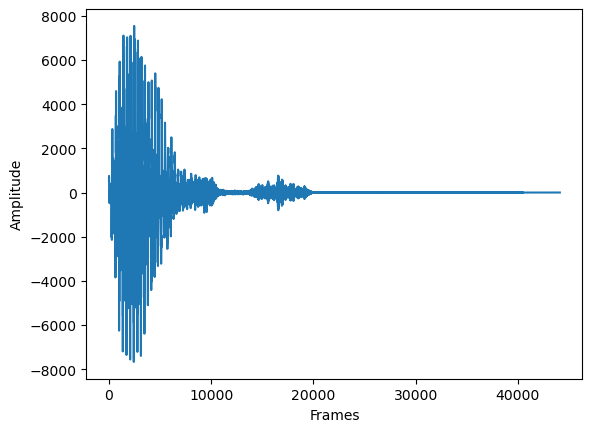

In [105]:
def normInput(decoded):
    for i, v in enumerate(decoded):
        if v > 500:
            decoded = decoded[i:]
            break
    if len(decoded) > SAMPLEFREQ:
        decoded = decoded[:SAMPLEFREQ]
    while len(decoded) < SAMPLEFREQ:
        np.append(decoded, 0)
    return decoded

plt.plot(normInput(data))
plt.ylabel("Amplitude")
plt.xlabel("Frames")
plt.show()

In [106]:
%%script false

typ = "TestDaten"
befehl = ""
name = "hannes"
for i in range(5):
    print("Start")
    data = normInput(recordAudio())
    if len(name) == 0:
        np.save(f"Messdaten/{typ}/{befehl}/{befehl}{i}", data)
    else:
        np.save(f"Messdaten/{typ}/{name}/{befehl}/{befehl}{i}", data)
    plt.plot(data)
    plt.show()

Couldn't find program: 'false'


# Import npy file

In [107]:
data = np.load("Messdaten/Referenzen/hoch/hoch0.npy")

# Amplitudenspektrum

Text(0.5, 1.0, 'Amplitude Spectrum')

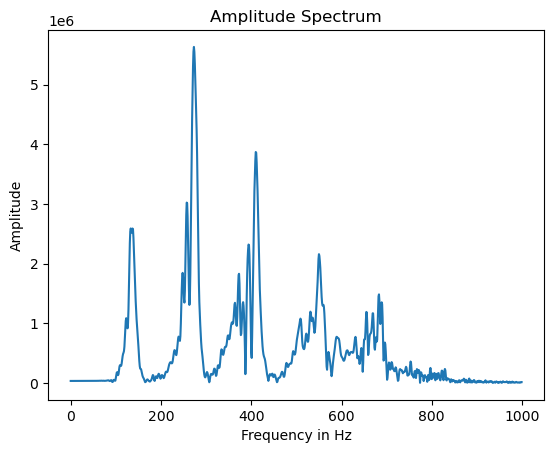

In [108]:
fourier_transform = np.fft.fft(data)
amplituden = np.abs(fourier_transform)
freq = np.fft.fftfreq(len(amplituden), d=1/SAMPLEFREQ)

plt.plot(freq[:1000], amplituden[:1000])
plt.xlabel('Frequency in Hz')
plt.ylabel('Amplitude')
plt.title('Amplitude Spectrum')

# Windowing

In [123]:
def windowing(win_data, gaus=True):
    windowSize = 512
    window = win.gaussian(windowSize, std=windowSize/4)
    windows_fft = []

    for i in range(0, SAMPLEFREQ, int(windowSize/2)):
        localData = win_data[i:i+windowSize]
        if len(localData) != 512:
            continue
        if gaus:
            local_fft = np.abs(np.fft.fft(localData*window))
        else:
            local_fft = np.fft.fft(localData)
        windows_fft.append(local_fft)
    mean_fft = np.array(windows_fft).mean(axis=0)
    return mean_fft

(512,)
[    0.           86.1328125   172.265625    258.3984375   344.53125
   430.6640625   516.796875    602.9296875   689.0625      775.1953125
   861.328125    947.4609375  1033.59375    1119.7265625  1205.859375
  1291.9921875  1378.125      1464.2578125  1550.390625   1636.5234375
  1722.65625    1808.7890625  1894.921875   1981.0546875  2067.1875
  2153.3203125  2239.453125   2325.5859375  2411.71875    2497.8515625
  2583.984375   2670.1171875  2756.25       2842.3828125  2928.515625
  3014.6484375  3100.78125    3186.9140625  3273.046875   3359.1796875
  3445.3125     3531.4453125  3617.578125   3703.7109375  3789.84375
  3875.9765625  3962.109375   4048.2421875  4134.375      4220.5078125
  4306.640625   4392.7734375  4478.90625    4565.0390625  4651.171875
  4737.3046875  4823.4375     4909.5703125  4995.703125   5081.8359375
  5167.96875    5254.1015625  5340.234375   5426.3671875  5512.5
  5598.6328125  5684.765625   5770.8984375  5857.03125    5943.1640625
  6029.296875  

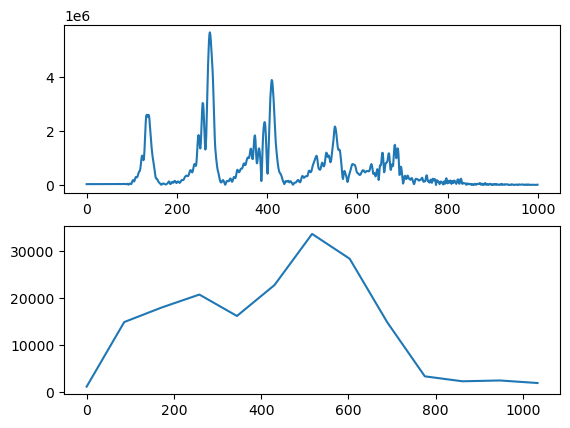

In [129]:
mg = windowing(data)
og = windowing(data, False)[:60]

# plt.subplot(2, 1, 1)
# plt.plot(mg)
# plt.legend(["mit Gaus"])
# plt.subplot(2, 1, 2)
# plt.plot(og)
# plt.legend(["ohne Gaus"])
# plt.show()
# plt.plot(mg)
# plt.plot(og)
# plt.legend(["mit Gaus", "ohne Gaus"])
# plt.show()


window = windowing(data)
print(window.shape)
plt.subplot(2, 1, 1)
plt.plot(freq[:1000], amplituden[:1000])
plt.subplot(2, 1, 2)
abtastintervall = (512/44100) / 512
freq2 = np.abs(np.fft.fftfreq(512, d=1/SAMPLEFREQ))
print(freq2)
plt.plot(freq2[:13], window[:13])

plt.show()


# Daten einlesen

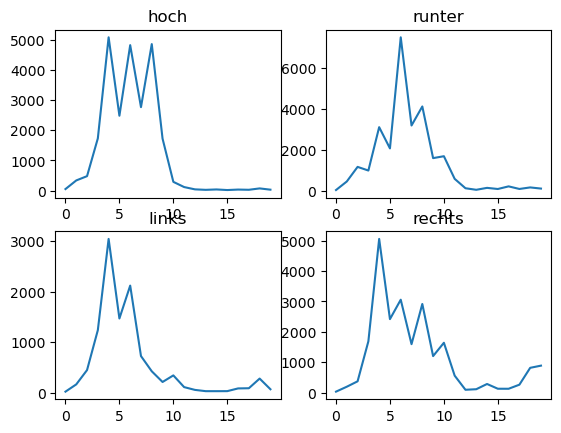

In [111]:

befehle = ["hoch", "runter", "links", "rechts"]

ref_dict = {}
for idx_befehl, befehl in enumerate(befehle):
    ref_dict[befehl] = []
    for i in range(5):
        data = np.load(f"Messdaten/Referenzen/{befehl}/{befehl}{i}.npy")
        ref_dict[befehl].append(windowing(data))
    ref_dict[befehl] = np.array(ref_dict[befehl]).mean(axis=0)
    plt.subplot(2, 2, idx_befehl + 1)
    plt.plot(ref_dict[befehl][:20])
    plt.title(befehl)

plt.show()


# Testdatensätze

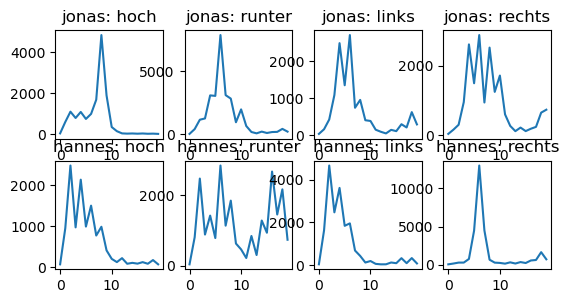

In [112]:
tests_dict = {}
namen = ["jonas", "hannes"]

for idx_name, name in enumerate(namen):
    tests_dict[name] = {}
    for idx_befehl, befehl in enumerate(befehle):
        tests_dict[name][befehl] = []
        for i in range(5):
            data = np.load(f"Messdaten/TestDaten/{name}/{befehl}/{befehl}{i}.npy")
            tests_dict[name][befehl].append(windowing(data))
        tests_dict[name][befehl] = np.array(tests_dict[name][befehl]).mean(axis=0)
        plt.subplot(3, 4, idx_name*4 + idx_befehl + 1)
        plt.plot(tests_dict[name][befehl][:20])
        plt.title(f"{name}: {befehl}")

plt.show()


# Korrelation

In [113]:
def std_ab(d):
    mean = np.mean(d)
    return np.sqrt(sum(np.power(x - mean, 2) for x in d) / len(d))

def get_korr(input, ref):
    xMean = np.mean(input)
    yMean = np.mean(ref)
    length = len(input)
    kovarianz = sum((x - xMean) * (y - yMean)for x, y in zip(input, ref)) / length
    return kovarianz / (std_ab(input) * std_ab(ref))



# Vergleich

In [114]:
korr_dict = {}
for befehl in befehle:
    korr_dict[befehl] = {}
    ref = ref_dict[befehl]
    for name in namen:
        korr_dict[befehl][name] = get_korr(tests_dict[name][befehl], ref)


for befehl, names in korr_dict.items():
    for name, korr in names.items():
        print(f"{name} mit Befehlt {befehl} korreliert mit {korr}")



jonas mit Befehlt hoch korreliert mit 0.7972737853330626
hannes mit Befehlt hoch korreliert mit 0.7632196007388696
jonas mit Befehlt runter korreliert mit 0.9820560553479281
hannes mit Befehlt runter korreliert mit 0.6776570295045815
jonas mit Befehlt links korreliert mit 0.9464435450256306
hannes mit Befehlt links korreliert mit 0.7595675016666537
jonas mit Befehlt rechts korreliert mit 0.9218436714061357
hannes mit Befehlt rechts korreliert mit 0.5780556777602665


## Testdaten verglichen mit allen Referenzen

In [115]:
# befehl_dict {"hoch", daten, "rechts", daten, usw.}
for name, befehl_dict in tests_dict.items():
    score = 0
    print(f"{name.title()}:")

    for befehl, testDaten in befehl_dict.items():
        korrs = []
        # ref_befehl = welcher befehl (zb. "hoch"), ref = refDaten
        for ref_befehl, ref in ref_dict.items():

            korrs.append((ref_befehl, get_korr(testDaten, ref)))
        korrs.sort(key=lambda t: t[1], reverse=True)
        print(f"'{befehl.title()}' Korreliert am besten mit '{korrs[0][0].title()}': {korrs[0][1]}")
        if befehl == korrs[0][0]:
            score += 1
    print(f"Score: {(score / 4) * 100}%")


Jonas:
'Hoch' Korreliert am besten mit 'Hoch': 0.7972737853330626
'Runter' Korreliert am besten mit 'Runter': 0.9820560553479281
'Links' Korreliert am besten mit 'Links': 0.9464435450256306
'Rechts' Korreliert am besten mit 'Rechts': 0.9218436714061357
Score: 100.0%
Hannes:
'Hoch' Korreliert am besten mit 'Links': 0.7639030721917255
'Runter' Korreliert am besten mit 'Runter': 0.6776570295045815
'Links' Korreliert am besten mit 'Links': 0.7595675016666537
'Rechts' Korreliert am besten mit 'Runter': 0.7985210063956426
Score: 50.0%
